In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split,cross_validate

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

print(tf.__version__)

df = pd.read_excel('/content/Test_dataset.xlsx')
df.set_index('Date', inplace=True)
print(df.columns)

# df.info()
# split_time = 420



2.8.0
Index(['index', 'Target', 'shift_down', 'week', 'MA5', 'MA5_f', 'w_inc',
       'w_inc_UD', 'w_inc_CT', '1)환율-RMB', '1)철광석-중국', '1)원료탄', '1)철스크랩',
       '1)열연-미국', '1)열연-뭄바이', '1)열연-천진', '1)열연-상해', '1)열연-중국수출', '1)열연-북유럽',
       '1)열연-남유럽', '1)열연-한국', '1)GI-상해', '1)GI-중국수출', '1)GI-북유럽', '1)GI-남유럽',
       '1)GI-미국', '1)GI-미중서', '1)GI-한국', '2)열연-중국천진', '2)열연-중국상해',
       '2)중국-Plate상해', '2)중국-Flat재고', '3)Rebar-중국', '3)W/Rod-상해',
       '3)Billet-중국내수', '3)중국-Long재고', '3)중국-판재+롱재고', '4)철광석', '4)호주-석탄',
       '4)중국-석탄내수', '4)철스크랩-터키수입가', '5)두바이', '5)WTI', '5)BDI', '5)BSI-해운지수',
       'Year', 'Quater', 'Quater_ver2', 'Month', 'Day'],
      dtype='object')


In [2]:
Y_colname = ['w_inc_UD']
# X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
# X_colname = [x for x in raw_fe.columns if x not in Y_colname+X_remove]
X_colname = ['Target', 'MA5','1)철광석-중국', '4)철스크랩-터키수입가', '5)WTI', '5)BSI-해운지수', '2)중국-Flat재고', '3)중국-판재+롱재고', '4)중국-석탄내수', 
             '1)열연-미국', '1)열연-뭄바이', '1)열연-북유럽', '1)열연-한국', '1)GI-상해', '1)GI-미국']



# 예측값 : 다음주 평균가격

Dataset = df[X_colname+Y_colname]
# Dataset = df[Y_colname]
Dataset = Dataset.dropna(axis=0)  # 데이터 없는거 지우기 (앞부분)


print(Dataset)

            Target    MA5    1)철광석-중국  4)철스크랩-터키수입가  5)WTI  5)BSI-해운지수  \
Date                                                                     
2019-12-30   483.0  481.0   95.743000         301.0  61.68       728.0   
2019-12-31   483.0  482.0   95.944000         301.0  61.06       728.0   
2020-01-01   483.0  483.0   95.944000         301.0  61.06       728.0   
2020-01-02   485.0  483.4   96.803200         301.0  61.18       685.0   
2020-01-03   485.0  483.8   97.648000         300.0  63.05       662.0   
...            ...    ...         ...           ...    ...         ...   
2022-01-26   765.0  760.0  140.800506         470.0  87.35      1654.0   
2022-01-27   770.0  762.8  140.473823         470.0  86.61      1613.0   
2022-01-28   777.0  766.6  147.810362         473.0  86.82      1597.0   
2022-01-31   777.0  770.2  147.024137         483.0  88.15      1587.0   
2022-02-01   777.0  773.2  147.024137         484.0  88.20      1578.0   

            2)중국-Flat재고  3)중국-판재+롱재고 

In [3]:
# 추가 모델을 적용하고자 함

# 정규화 함수 
def MinMaxScaler(data):
    denom = np.max(data,0)-np.min(data,0)
    nume = data-np.min(data,0)
    return nume/denom

# 정규화 되돌리기 함수 
def back_MinMax(data,value):
    diff = np.max(data,0)-np.min(data,0)
    back = value * diff + np.min(data,0)
    return back 


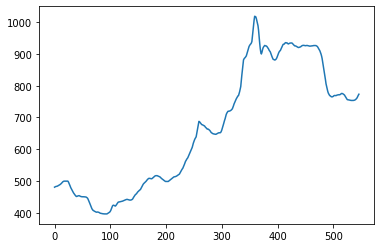

(547, 16)


In [6]:
xy= np.array(Dataset)
#print(xy[:,1])

#%matplotlib notebook
plt.plot(xy[:,1])    # 해당주 평균가격
plt.show()
print(xy.shape)

In [67]:
seqLength = 1 # window size 
dataDim = 15 # feature 개수
hiddenDim = 10 
outputDim = 1
lr = 0.01
iterations = 300

#Dataset 구분 : Train 비율 80%, Test 비율 20%
trainSize = int(len(xy)*0.8)
trainSet = xy[0:trainSize]
testSet = xy[trainSize-seqLength:]

trainSet = MinMaxScaler(trainSet)
testSet = MinMaxScaler(testSet)


# 20일간의 15가지 데이터(00, 00, 00, ,, ,,)를 받아와서 
# 다음주 평균가격을 예측하는 모델로 구성

def buildDataSet(timeSeries, seqLength):
    xdata = []
    ydata = [] 
    for i in range(0, len(timeSeries)-seqLength):
        tx = timeSeries[i:i+seqLength,:-1]
        ty = timeSeries[i+seqLength-1,[-1]]
        xdata.append(tx)
        ydata.append(ty)
    return np.array(xdata), np.array(ydata)
    
trainX, trainY=buildDataSet(trainSet, seqLength)
testX, testY=buildDataSet(testSet, seqLength)

In [76]:
# trainX.shape
print(testSet)
# trainY.shape

[[0.96       0.96997691 1.         ... 0.96646545 0.82765957 1.        ]
 [0.94857143 0.96189376 0.88850796 ... 0.94669218 0.91489362 1.        ]
 [0.94857143 0.96073903 0.8885717  ... 0.94686338 0.91489362 1.        ]
 ...
 [0.13714286 0.07505774 0.72597936 ... 0.02144612 0.         1.        ]
 [0.13714286 0.09584296 0.71588885 ... 0.02144612 0.         1.        ]
 [0.13714286 0.11316397 0.71588885 ... 0.02144612 0.         1.        ]]


In [49]:
# (MLP는 단순 참조용으로 구성)
# 1) MLP 모델 구성 

# First, let's define a RNN Cell, as a layer subclass.
from tensorflow import keras
from tensorflow.keras import layers

#model = keras.Sequential()

#model.add(layers.SimpleRNN(units=32, return_sequences=True, 
#                           activation='relu',
#                           input_shape=[seqLength ,dataDim -1]))
#model.add(layers.SimpleRNN(16), activation='relu')
#model.add(layers.Dense(16), activation='relu')
#model.add(layers.Dense(1))


model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[seqLength ,dataDim]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1, activation="sigmoid")
])


model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 10, 10)            160       
                                                                 
 dense_15 (Dense)            (None, 10, 10)            110       
                                                                 
 dense_16 (Dense)            (None, 10, 1)             11        
                                                                 
Total params: 281
Trainable params: 281
Non-trainable params: 0
_________________________________________________________________


In [69]:
# 2) RNN 모델 구성 

# First, let's define a RNN Cell, as a layer subclass.
from tensorflow import keras
from tensorflow.keras import layers

#model = keras.Sequential()

#model.add(layers.SimpleRNN(units=32, return_sequences=True, 
#                           activation='relu',
#                           input_shape=[seqLength ,dataDim -1]))
#model.add(layers.SimpleRNN(16), activation='relu')
#model.add(layers.Dense(16), activation='relu')
#model.add(layers.Dense(1))


model = tf.keras.models.Sequential([
  tf.keras.layers.SimpleRNN(10, activation="relu", input_shape=[seqLength ,dataDim]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1, activation="sigmoid")
])


model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 10)                260       
                                                                 
 dense_17 (Dense)            (None, 10)                110       
                                                                 
 dense_18 (Dense)            (None, 1)                 11        
                                                                 
Total params: 381
Trainable params: 381
Non-trainable params: 0
_________________________________________________________________


In [70]:
# 모델 학습과정 설정 
# model.compile(loss='mse', optimizer='adam', metrics=['mae'])

from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])


# 모델 트레이닝 
history = model.fit(trainX, trainY, epochs=300, batch_size=20)

# history = model.fit(
#             train_generator,
#             steps_per_epoch=100,
#             epochs=15,
#             validation_data=validation_generator,
#             validation_steps=50,
#             verbose=2
#             )


Epoch 1/300
22/22 [==============================] - 1s 2ms/step - loss: 0.6456 - accuracy: 0.6560
Epoch 2/300
22/22 [==============================] - 0s 2ms/step - loss: 0.6347 - accuracy: 0.6445
Epoch 3/300
22/22 [==============================] - 0s 3ms/step - loss: 0.6316 - accuracy: 0.6445
Epoch 4/300
22/22 [==============================] - 0s 2ms/step - loss: 0.6286 - accuracy: 0.6445
Epoch 5/300
22/22 [==============================] - 0s 2ms/step - loss: 0.6243 - accuracy: 0.6445
Epoch 6/300
22/22 [==============================] - 0s 2ms/step - loss: 0.6203 - accuracy: 0.6583
Epoch 7/300
22/22 [==============================] - 0s 2ms/step - loss: 0.6168 - accuracy: 0.6628
Epoch 8/300
22/22 [==============================] - 0s 2ms/step - loss: 0.6132 - accuracy: 0.6628
Epoch 9/300
22/22 [==============================] - 0s 2ms/step - loss: 0.6101 - accuracy: 0.6766
Epoch 10/300
22/22 [==============================] - 0s 2ms/step - loss: 0.6070 - accuracy: 0.6881
Epoch 11/

In [71]:
# 모델에 대한 정확도 평가
loss, accuracy = model.evaluate(trainX, trainY, verbose = 1)
accuracy = accuracy*100
print(" - Train 정확도 :", '%0.1f' % accuracy, "%\n")

loss, accuracy = model.evaluate(testX, testY, verbose = 1)
accuracy = accuracy*100
print(" - Test 정확도 :", '%0.1f' % accuracy, "%\n")

14/14 [==============================] - 0s 2ms/step - loss: 0.4015 - accuracy: 0.8349
 - Train 정확도 : 83.5 %

4/4 [==============================] - 0s 4ms/step - loss: 1.9759 - accuracy: 0.3909
 - Test 정확도 : 39.1 %



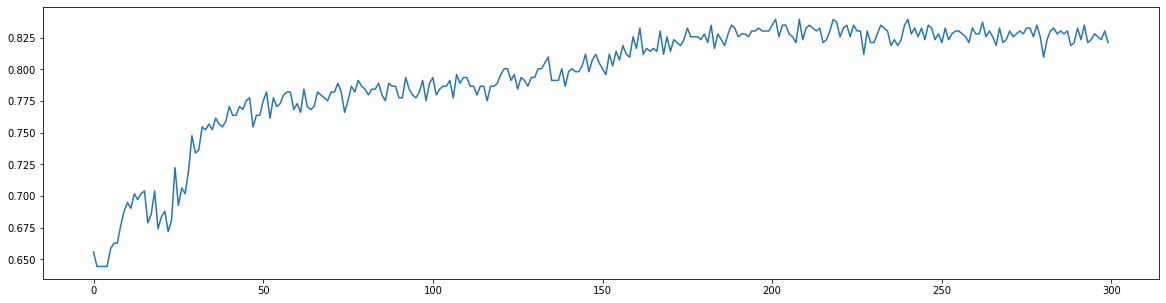

In [72]:
plt.figure(figsize = (20,5))

plt.plot(history.history['accuracy'])

In [73]:
y_hat = model.predict(testX)

# print(y_hat)

y_hat = np.where(y_hat < 0.5, 0, 1)
print(y_hat.shape)
print(testY.shape)


# y_hat_flt = y_hat.flatten()
# testY_flt = testY.flatten()
# print(y_hat_flt)
# print(testY_flt)

(110, 1)
(110, 1)


In [74]:
score = ( np.mean(testY == y_hat) ) *100

# score = ( np.mean(testY_flt == y_hat_flt) ) *100
# print(score)
print("\n< 분류에 대한 ML > - RNN 기본모형 적용\n")
print(" * 테스트 기간\n")
print(" - 정확도(%) :", '%0.1f' % score, "%\n")


< 분류에 대한 ML > - RNN 기본모형 적용

 * 테스트 기간

 - 정확도(%) : 39.1 %



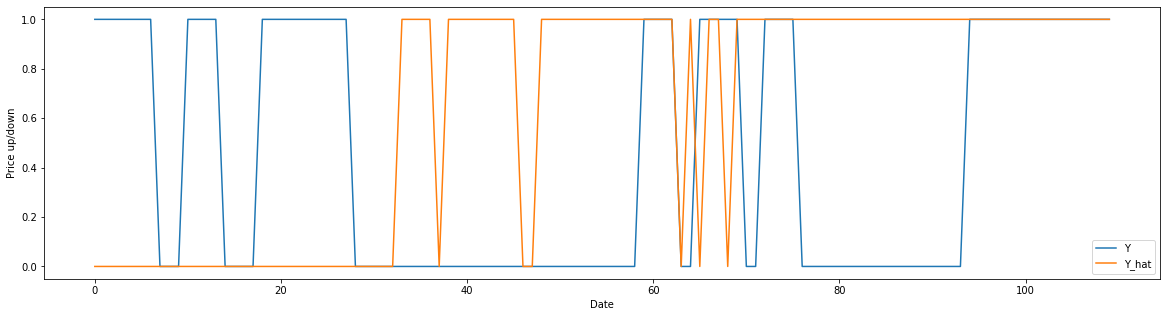

In [75]:
plt.figure(figsize = (20,5))

# ax1 = sns.distplot(test_actual, hist=False, label="Y")
# ax2 = sns.distplot(test_predict, hist=False, label="Y_hat")


# print("\n2) Test data - 정확성 체크")

plt.plot(testY)     # 실제 가격
plt.plot(y_hat)     # 예측 가격

plt.xlabel('Date')
plt.ylabel('Price up/down')
plt.legend(labels=["Y", "Y_hat"], loc = 'best')
plt.show()